<a href="https://colab.research.google.com/github/barankutluay/deep-learning-projects/blob/main/Fruits360_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title # Upgrade Tensorflow { vertical-output: true, form-width: "33%", display-mode: "form" }

import sys
import warnings

# Redirect stderr to stdout
sys.stderr = sys.stdout
warnings.filterwarnings("ignore")

# Imports
import os
import glob
import random
import zipfile
import gzip
import pytz
import datetime
import numpy as np
import pandas as pd
import json
import concurrent.futures
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


print("INFO: TensorFlow version:", tf.__version__)

if tf.__version__ != "2.13.0":
    print("INFO: TensorFlow will be updated.")

    os.system("pip install tensorflow --upgrade")

    # Define the reason for restarting the runtime
    restart_reason = "Updating dependencies and configurations"

    # Display a warning message
    warning_message = f"WARNING: Runtime will restart because: {restart_reason}"
    print(warning_message)

    os.kill(os.getpid(), 9)
else:
    print("INFO: TensorFlow has been updated before.")
    # Check if keras_cv is already installed
    try:
        import pkg_resources
        pkg_resources.get_distribution("keras-cv") and pkg_resources.get_distribution("python-dotenv")
    except pkg_resources.DistributionNotFound:
        # If not installed, install it
        os.system("pip install keras-cv python-dotenv")

    import keras_cv
    from dotenv import load_dotenv

INFO: TensorFlow version: 2.13.0
INFO: TensorFlow has been updated before.
Using TensorFlow backend


In [2]:
# @title # Configuration { vertical-output: true, form-width: "33%", display-mode: "form" }

ACCELERATOR = "TPU" # @param ["TPU", "GPU", "None"]
GPU_MEMORY_LIMIT_GB = 10 # @param {type:"slider", min:2, max:24, step:2}

ACCELERATOR = None if ACCELERATOR == "None" else ACCELERATOR
TPU, TPU_STRATEGY = None, None

def configure_notebook(accelerator=None):
    global TPU, TPU_STRATEGY
    if accelerator == "TPU":
        # Connect to TPU
        TPU = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        TPU_STRATEGY = tf.distribute.TPUStrategy(TPU)
        TPU_ADDRESS = f"grpc://{TPU.cluster_spec().as_dict()['worker'][0]}"
        devices = tf.config.list_logical_devices("TPU")
        # tf.config.set_soft_device_placement(True)
        print("INFO: TPU has been connected. TPU Address:", TPU_ADDRESS)
        print("\nTPU Devices:")
        for device in devices:
            print(f"{device.name[-12:-5]} {device.name[-5:-2]} {device.name[-1:]}")

    elif accelerator == "GPU":
        print("All Devices:")
        gpus = tf.config.list_physical_devices("GPU")
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, False)
                tf.config.experimental.set_virtual_device_configuration(
                    gpu,
                    [tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=GPU_MEMORY_LIMIT_GB * 1024
                    )]
                )
            tf.config.set_visible_devices(gpus[0], "GPU")
            logical_gpus = tf.config.list_logical_devices("GPU")
            print(f"{len(gpus)} Physical GPU/GPUs, {len(logical_gpus)} Logical GPU/GPUs")

    else:
        cpus = tf.config.list_physical_devices("CPU")
        logical_cpus = tf.config.list_logical_devices("CPU")
        print(f"{len(cpus)} Physical CPU/CPUs, {len(logical_cpus)} Logical CPU/CPUs")


configure_notebook(accelerator=ACCELERATOR)

print("\nINFO: The configuration process is complete.")

INFO: TPU has been connected. TPU Address: grpc://10.39.171.186:8470

TPU Devices:
device: TPU 0
device: TPU 1
device: TPU 2
device: TPU 3
device: TPU 4
device: TPU 5
device: TPU 6
device: TPU 7

INFO: The configuration process is complete.


In [3]:
# @title # Download the Data { vertical-output: true, form-width: "33%", display-mode: "form" }

# @markdown # Configuration:
DATA_SOURCE = "Kaggle" # @param ["Kaggle", "Other"]
PROJECT_NAME = "Fruits360_VGG16" # @param {type:"string"}

# @markdown ## Directories:
# @markdown Root directory:
DATASET_DIR = "fruits-360_dataset/fruits-360" # @param {type:"string"}
# @markdown Directory that contains training files:
TRAIN_DIR = "Training" # @param {type:"string"}
# @markdown Directory that contains testing files:
TEST_DIR = "Test" # @param {type:"string"}

# @markdown ## Image Dimensions:
IMG_HEIGHT = 100 # @param {type:"integer"}
IMG_WIDTH = 100 # @param {type:"integer"}
CHANNELS = 3 # @param ["1", "3", "4"] {type:"raw"}

# @markdown ## Notes:
# @markdown If data source is Kaggle, upload .env file that
# @markdown contains your credentials to the Google Drive. Then you can specify
# @markdown username and dataset name. \\
# @markdown Usage: https://www.kaggle.com/datasets/{username}/{dataset_name}

# @markdown ### If data source is Kaggle:
if DATA_SOURCE == "Kaggle":
    USERNAME = "moltean" # @param {type:"string"}
    DATASET_NAME = "fruits" # @param {type:"string"}
    ENV_PATH = "/content/drive/MyDrive/.env"

# @markdown ### If data source is Other:
if DATA_SOURCE == "Other":
    LIST_OF_LINKS = [] # @param {type:"raw"}

# Define paths based on the notebook environment
COLAB_WORKING_PATH = os.path.abspath(PROJECT_NAME)
DRIVE_PATH = os.path.abspath("drive")

# Function to download and extract the dataset
def download_and_extract_dataset(dataset:str=None, urls:list=None, gzfile:bool=False):
    if DATA_SOURCE == "Kaggle":
        # Mount Google Drive if not already mounted
        from google.colab import drive
        drive_mounted = os.path.exists(DRIVE_PATH)
        if not drive_mounted:
            drive.mount(DRIVE_PATH)

        load_dotenv(ENV_PATH)  # Load Kaggle credentials from .env

        print("\nINFO: Kaggle API Authentication successful.")

        zip_file_path = f"{dataset.split('/')[-1]}.zip"

        if not os.path.exists(zip_file_path):
            os.system(f"kaggle datasets download -d {dataset}")

        print("INFO: Downloading finished.")

        extracted_dir = os.path.abspath(PROJECT_NAME)

        # Create the extraction directory if it doesn't exist
        if not os.path.exists(extracted_dir):
            os.makedirs(extracted_dir)

        # Extract the contents of the zip file
        if not os.listdir(extracted_dir):
            with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
                zip_ref.extractall(extracted_dir)
            print("INFO: Extraction completed.")
        else:
            print("INFO: Extraction already completed. Skipping...")

        print(f"INFO: Contents of {zip_file_path} extracted to \"{extracted_dir}\".")

        if not os.path.exists(COLAB_WORKING_PATH):
            os.makedirs(COLAB_WORKING_PATH)

        train_path = os.path.join(COLAB_WORKING_PATH, DATASET_DIR, TRAIN_DIR)
        test_path = os.path.join(COLAB_WORKING_PATH, DATASET_DIR, TEST_DIR)

        print()
        print(f"Train Path: {train_path}")
        print(f"Test Path: {test_path}")

        return train_path, test_path

    if DATA_SOURCE == "Other":
        import shutil
        img_size = (IMG_HEIGHT, IMG_WIDTH)

        for url in urls:
            file_path = keras.utils.get_file(
                origin=url,
                extract=True,
            )

            if file_path.endswith(".gz") and not file_path.endswith(".tar.gz") and gzfile:
                extract_dir = os.path.dirname(file_path)

                with gzip.open(file_path, "rb") as f_in:
                    if "images" in file_path:
                        # For image data files
                        data = np.frombuffer(f_in.read(), dtype=np.uint8, offset=16)  # Skip the header
                        num_pixels = img_size[0] * img_size[1]
                        data = data.reshape(-1, num_pixels)  # Reshape the data
                        if "train" in file_path:
                            X_train = data
                        else:
                            X_test = data

                    elif "labels" in file_path:
                        # For label data files
                        data = np.frombuffer(f_in.read(), dtype=np.uint8, offset=8)  # Skip the header
                        if "train" in file_path:
                            y_train = data
                        else:
                            y_test = data

                    print(f"\nINFO: Downloading and extraction finished: {file_path.split(os.path.sep)[-1]}")

                os.remove(file_path)
                return (X_train, y_train), (X_test, y_test)

        print(f"\nINFO: Downloading and extraction finished: {file_path.split(os.path.sep)[-1]}")

        if os.path.exists(COLAB_WORKING_PATH):
            shutil.rmtree(COLAB_WORKING_PATH)

        os.makedirs(COLAB_WORKING_PATH, exist_ok=True)

        dataset_dir = "/root/.keras/datasets"
        for folder in os.listdir(dataset_dir):
            shutil.move(os.path.join(dataset_dir, folder), COLAB_WORKING_PATH)

        train_path = os.path.join(COLAB_WORKING_PATH, DATASET_DIR, TRAIN_DIR)
        test_path = os.path.join(COLAB_WORKING_PATH, DATASET_DIR, TEST_DIR)

        print()
        print(f"Train Path: {train_path}")
        print(f"Test Path: {test_path}")

        return train_path, test_path

# Call the download_and_extract_dataset function with Kaggle data source
TRAIN_PATH, TEST_PATH = download_and_extract_dataset(os.path.join(USERNAME, DATASET_NAME))

# Define input shape
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
print(f"Input Shape: {INPUT_SHAPE}\n")


INFO: Kaggle API Authentication successful.
INFO: Downloading finished.
INFO: Extraction already completed. Skipping...
INFO: Contents of fruits.zip extracted to "/content/Fruits360_VGG16".

Train Path: /content/Fruits360_VGG16/fruits-360_dataset/fruits-360/Training
Test Path: /content/Fruits360_VGG16/fruits-360_dataset/fruits-360/Test
Input Shape: (100, 100, 3)



In [4]:
# @title # Load the Dataset { vertical-output: true, form-width: "33%", display-mode: "form" }

# @markdown # Configuration:
VALIDATION_SPLIT = 0.2 # @param {type:"slider", min:0, max:1, step:0.1}
NUM_CLASSES = 131 # @param {type:"integer"}
LABEL_MODE = "categorical" # @param ["int", "categorical", "binary"]

# Function to load and decode an image
def load_and_decode_image(label, directory, image_file):
    file_path = os.path.join(directory, image_file)
    with tf.io.gfile.GFile(file_path, "rb") as f:
        image_data = f.read()
        image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    return image, label

# Function to load images and labels
def load_images_and_labels(parent_directory, executor):
    subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    images = []
    labels = []

    for label, subdirectory in enumerate(subdirectories):
        directory = os.path.join(parent_directory, subdirectory)
        image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

        # Use executor.map to parallelize loading and decoding
        results = list(executor.map(load_and_decode_image, [label] * len(image_files), [directory] * len(image_files), image_files))
        image_batch, label_batch = zip(*results)
        images.extend(image_batch)
        labels.extend([label] * len(image_files))

    labels = keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)  # One-hot encode the labels
    return images, labels

# Function to load datasets
def load_dataset(validation_split=None):
    validation_split = None if validation_split == 0 else validation_split

    if ACCELERATOR == "TPU":
        with concurrent.futures.ThreadPoolExecutor() as executor:
            train_images, train_labels = load_images_and_labels(TRAIN_PATH, executor)
            test_images, test_labels = load_images_and_labels(TEST_PATH, executor)

        num_validation_samples = int(len(train_images) * validation_split) if validation_split else 0

        train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
        train_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=1).skip(num_validation_samples)
        test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(buffer_size=len(train_ds))

        if validation_split:
            val_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=1).take(num_validation_samples)
            return train_ds, val_ds, test_ds
        else:
            return train_ds, test_ds

    if ACCELERATOR == "GPU":
        def load_dataset(path, subset=None):
            subset = None if validation_split is None else subset

            return keras.utils.image_dataset_from_directory(
                path,
                labels="inferred",
                label_mode=LABEL_MODE,
                color_mode="rgba" if CHANNELS == 4 else "grayscale" if CHANNELS == 1 else "rgb",
                batch_size=None,
                image_size=(IMG_HEIGHT, IMG_WIDTH),
                shuffle=True,
                seed=1,
                validation_split=validation_split,
                subset=subset
            )

        train_ds = load_dataset(TRAIN_PATH, subset="training", validation_split=validation_split)
        test_ds = load_dataset(TEST_PATH)

        if validation_split:
            val_ds = load_dataset(TRAIN_PATH, subset="validation", validation_split=validation_split)
            return train_ds, val_ds, test_ds
        else:
            return train_ds, test_ds

# Load the datasets
if VALIDATION_SPLIT != 0:
    train_ds, val_ds, test_ds = load_dataset(validation_split=VALIDATION_SPLIT)
    print(f"================== INFO ==================")
    print(f"Length of the Training Dataset: {len(train_ds)}")
    print(f"Length of the Validation Dataset: {len(val_ds)}")
    print(f"Length of the Testing Dataset: {len(test_ds)}")
else:
    train_ds, test_ds = load_dataset()
    print(f"================== INFO ==================")
    print(f"Length of the Training Dataset: {len(train_ds)}")
    print(f"Length of the Testing Dataset: {len(test_ds)}")

================== INFO ==================
Length of the Training Dataset: 54154
Length of the Validation Dataset: 13538
Length of the Testing Dataset: 22688


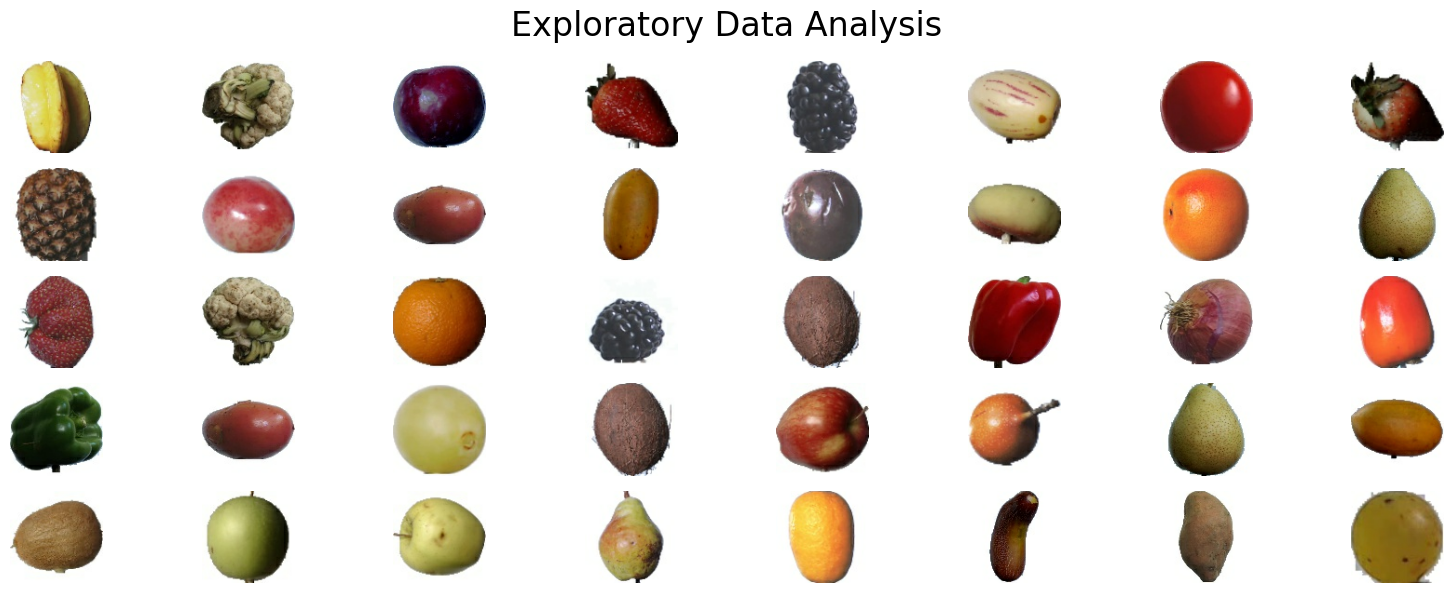

In [5]:
# @title # Explatory Data Analysis { vertical-output: true, form-width: "33%", display-mode: "form" }

NUM_ROWS = 5 # @param {type:"integer"}
NUM_COLUMNS = 8 # @param {type:"integer"}
NUM_SAMPLES = 40 # @param {type:"integer"}
# @markdown Default: "viridis"
CMAP = "viridis" # @param ["viridis", "gray", "binary", "plasma", "inferno", "magma", "cividis", "cool", "hot"]

# Function for EDA
def exploratory_data_analysis(num_samples, num_rows, num_cols):
    plt.figure(figsize=(16, 6))
    plt.suptitle("Exploratory Data Analysis", fontsize=24)

    if ACCELERATOR == "TPU":
        parent_directory = os.path.join(COLAB_WORKING_PATH, DATASET_DIR, TRAIN_DIR)
        subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
        images = []

        for _ in range(num_samples):
            random_subdirectory = random.choice(subdirectories)
            directory = os.path.join(parent_directory, random_subdirectory)
            image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

            if not image_files:
                continue  # Skip empty directories

            random_image = random.choice(image_files)
            file_path = os.path.join(directory, random_image)

            with tf.io.gfile.GFile(file_path, "rb") as f:
                image_data = f.read()
                image = tf.image.decode_jpeg(image_data, channels=CHANNELS)
                images.append(image)

        for i, image in enumerate(images):
            plt.subplot(num_rows, num_cols, i+1)
            plt.imshow(image.numpy().astype("float32") / 255.0, cmap=CMAP)
            plt.axis("off")

    if ACCELERATOR == "GPU":
        for i, (x, y) in enumerate(train_ds.take(num_samples)):
            image = x
            plt.subplot(num_rows, num_cols, i+1)
            plt.imshow(image.numpy().astype("float32") / 255.0, cmap=CMAP)
            plt.axis("off")

    plt.tight_layout()

# Perform EDA
exploratory_data_analysis(NUM_SAMPLES, NUM_ROWS, NUM_COLUMNS)

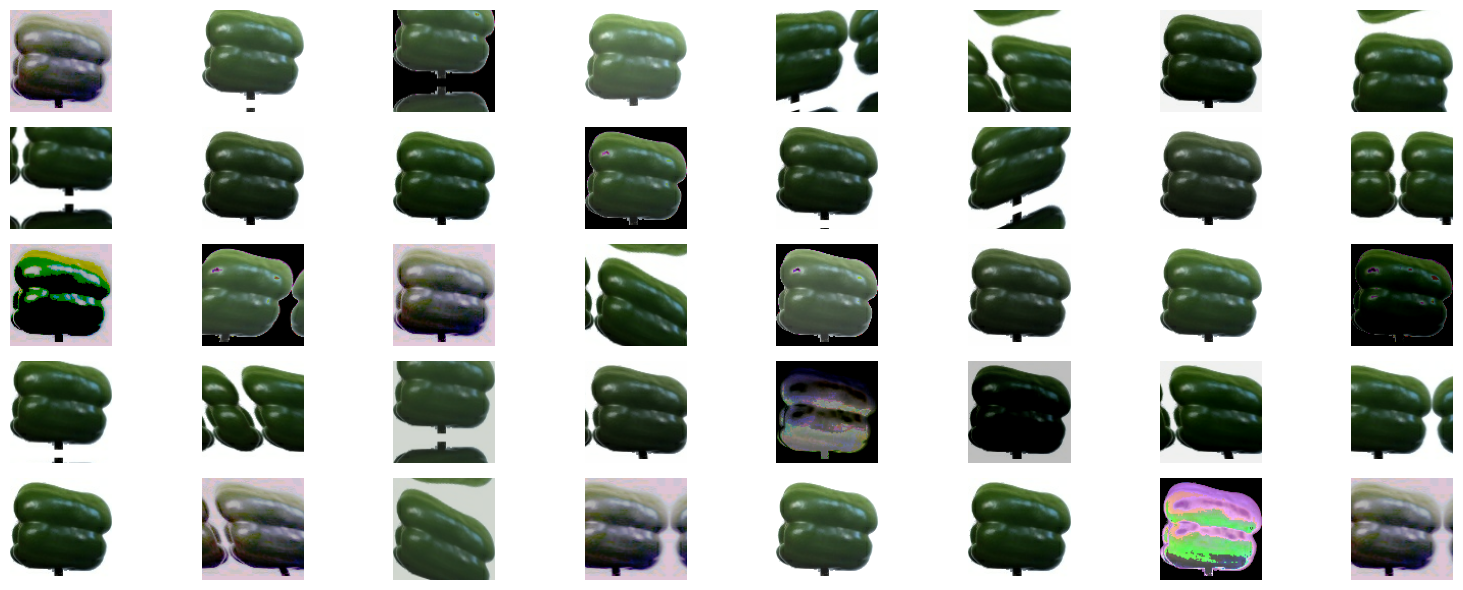

In [6]:
# @title # Data Augmentation { vertical-output: true, form-width: "33%", display-mode: "form" }

# @markdown # Configuration:
NUM_ROWS = 5 # @param {type:"integer"}
NUM_COLUMNS = 8 # @param {type:"integer"}
NUM_SAMPLES = 40 # @param {type:"integer"}
# @markdown If you want to apply GEOMETRICAL augmentation WITH COLOR:
AUGMENTATIONS_PER_IMAGE = 2 # @param ["1", "2", "3", "4", "5"] {type:"raw"}
MAGNITUDE = 0.3 # @param {type:"slider", min:0, max:1, step:0.01}
MAGNITUDE_STDDEV = 0.15 # @param {type:"slider", min:0, max:1, step:0.01}
# @markdown If you want to apply ONLY GEOMETRICAL augmentation:
FLIP_MODE = "horizontal" # @param ["horizontal", "vertical", "horizontal_and_vertical"]
FILL_MODE = "nearest" # @param ["reflect", "nearest", "wrap"]
TRANSLATION_HEIGHT_FACTOR = (-0.05, 0.05) # @param {type:"raw"}
TRANSLATION_WIDTH_FACTOR = (-0.05, 0.05) # @param {type:"raw"}
ZOOM_HEIGHT_FACTOR = (-0.2, 1) # @param {type:"raw"}
ROTATION_FACTOR = 0.05 # @param {type:"slider", min:0, max:1, step:0.01}

AUTO = tf.data.AUTOTUNE

def plot_augmentation(augmentation_fn, num_samples, num_rows, num_cols,
                      rgb_aug=False, only_geometrical=False):

    for x, y in train_ds.batch(1):
        image = x[0]
        break

    plt.figure(figsize=(16, 6))
    for i in range(num_samples):
        plt.subplot(num_rows, num_cols, i+1)
        if rgb_aug:
            plt.imshow(augmentation_fn(image).numpy() / 255.0, cmap=CMAP)
        elif only_geometrical:
            plt.imshow(
                augmentation_fn(
                    image.numpy().reshape(
                        -1, IMG_HEIGHT, IMG_WIDTH, CHANNELS
                    )
                ).numpy().reshape(
                    IMG_HEIGHT, IMG_WIDTH, CHANNELS
                ) / 255.0, cmap=CMAP
            )
        plt.axis("off")
    plt.tight_layout()

# RGB Augmentation Function
def rgb_augmentation_fn(image, label):
    image = rand_augment(image)
    return image, label

# Grayscale Augmentation Function
def grayscale_augmentation_fn(image, label):
    image = tf.reshape(
        geometrical_augment(
            tf.reshape(image, (-1, IMG_HEIGHT, IMG_WIDTH, CHANNELS))
        ),
        INPUT_SHAPE
    )
    return image, label

# Random Augmentation Layer
rand_augment = keras_cv.layers.RandAugment(
    value_range=[0, 255],
    augmentations_per_image=AUGMENTATIONS_PER_IMAGE,
    magnitude=MAGNITUDE,
    magnitude_stddev=MAGNITUDE_STDDEV
)

# Geometrical Augmentation Layer
geometrical_augment = keras.Sequential([
    keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    keras.layers.RandomFlip(
        mode=FLIP_MODE,
        name="rnd_flip_layer"
    ),
    keras.layers.RandomTranslation(
        height_factor=TRANSLATION_HEIGHT_FACTOR,
        width_factor=TRANSLATION_WIDTH_FACTOR,
        fill_mode=FILL_MODE,
        name="rnd_translation_layer"
    ),
    keras.layers.RandomZoom(
        height_factor=ZOOM_HEIGHT_FACTOR,
        fill_mode=FILL_MODE,
        name="rnd_zoom_layer"
    ),
    keras.layers.RandomRotation(
        factor=ROTATION_FACTOR,
        fill_mode=FILL_MODE,
        name="rnd_rotation_layer"
    ),
], name="geometrical_augment")

plot_augmentation(rand_augment, NUM_SAMPLES, NUM_ROWS, NUM_COLUMNS, rgb_aug=True)

In [7]:
# @title # Calculate the Imbalance Factor { vertical-output: true, form-width: "33%", display-mode: "form" }

from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights_and_counts(dataset_path):
    # Get a list of subdirectories (each subdirectory represents a class)
    class_dirs = [x for x in glob.glob(os.path.join(dataset_path, "*")) if os.path.isdir(x)]

    # Initialize dictionaries to store label counts and class weights
    label_counts = {}
    class_weights = {}

    for class_dir in class_dirs:
        class_name = os.path.basename(class_dir)
        # Count the number of files (samples) in each class directory
        num_samples = len(glob.glob(os.path.join(class_dir, "*")))
        label_counts[class_name] = num_samples

    # Calculate the imbalance factor
    max_count = max(label_counts.values())
    min_count = min(label_counts.values())
    imbalance_factor = max_count / min_count

    # Calculate class weights
    class_labels = [class_name for class_name, _ in label_counts.items()]
    y = np.repeat(class_labels, list(label_counts.values()))
    classes = np.unique(y)
    computed_class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)

    # Assign class weights to the dictionary
    for class_name, weight in zip(classes, computed_class_weights):
        class_weights[class_name] = weight

    # Create a DataFrame with the "Count" and "Class Weight" columns
    imbalance_df = pd.DataFrame([label_counts], columns=label_counts.keys(), index=["Count"])

    # Add a separate index for class weights
    imbalance_df.loc["Class Weight"] = imbalance_df.columns.map(class_weights)

    # Format the "Count" values
    imbalance_df.loc["Count"] = imbalance_df.loc["Count"].apply(lambda x: f"{int(x)}")

    return imbalance_df, imbalance_factor

imbalance_df, imbalance_factor = calculate_class_weights_and_counts(TRAIN_PATH)

print(f"Imbalance Factor: {imbalance_factor:.4f}")
print("Label Counts and Class Weights:\n")
display(imbalance_df)

Imbalance Factor: 3.3131
Label Counts and Class Weights:



,Nut Pecan,Pepper Red,Cucumber Ripe,Limes,Apple Crimson Snow,Apple Red 1,Cucumber Ripe 2,Kiwi,Apple Granny Smith,Apple Red Yellow 1,...,Plum 3,Cherry Wax Yellow,Pear Williams,Tomato not Ripened,Grape Pink,Apple Red Yellow 2,Guava,Pitahaya Red,Apple Golden 3,Apple Golden 1
Count,534,666,392,490,444,492,468,466,492,492,...,900,492,490,474,492,672,490,490,481,480
Class Weight,0.967664,0.775875,1.318196,1.054557,1.163813,1.05027,1.10413,1.108869,1.05027,1.05027,...,0.574148,1.05027,1.054557,1.090154,1.05027,0.768948,1.054557,1.054557,1.074289,1.076527


In [8]:
# @title # Create Data Pipelines { vertical-output: true, form-width: "33%", display-mode: "form" }

BATCH_SIZE = 128 # @param {type:"integer"}

STEPS_PER_EPOCH = len(train_ds) // BATCH_SIZE
VAL_STEPS = len(val_ds) // BATCH_SIZE

def create_data_pipeline(dataset, repeat=False, augment=False):
    if augment:
        if CHANNELS == 1:
            return (
                dataset
                .shuffle(buffer_size=len(dataset))
                .map(grayscale_augmentation_fn, num_parallel_calls=AUTO)
                .repeat()
                .batch(BATCH_SIZE)
                .prefetch(AUTO)
            )
        else:
            return (
                dataset
                .shuffle(buffer_size=len(dataset))
                .map(rgb_augmentation_fn, num_parallel_calls=AUTO)
                .repeat()
                .batch(BATCH_SIZE)
                .prefetch(AUTO)
            )
    elif repeat:
        return (
            dataset
            .shuffle(buffer_size=len(dataset))
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )
    else:
        return (
            dataset
            .shuffle(buffer_size=len(dataset))
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )

# Create data pipelines
val_ds = create_data_pipeline(val_ds)
test_ds = create_data_pipeline(test_ds)

print(f"INFO: Datasets have been perfectly shuffled, batched in size of {BATCH_SIZE} and prefetched.")

INFO: Datasets have been perfectly shuffled, batched in size of 128 and prefetched.


In [9]:
# @title # Base VGG16 Model { vertical-output: true, form-width: "33%", display-mode: "form" }

def basic_vgg16(include_top=False, weights="imagenet", input_shape: tuple=INPUT_SHAPE):
    # Get VGG16 model with ImageNet weights
    basic_vgg16 = keras.applications.vgg16.VGG16(
        include_top=include_top,
        weights=weights,
        input_shape=input_shape,
    )

    return basic_vgg16

basic_vgg16 = basic_vgg16()
basic_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [10]:
# @title # Customized VGG16 Model { vertical-output: true, form-width: "33%", display-mode: "form" }

LOSS = "categorical_crossentropy" # @param {type:"raw"}
METRICS = ["accuracy"] # @param {type:"raw"}
REGULARIZER = None # @param {type:"raw"}
DROPOUT_RATE = 0.5 # @param {type:"slider", min:0, max:1, step:0.01}

def Fruits360_VGG16(input_shape, num_classes, weights="imagenet", dropout_rate=0.5, regularizer=None):
    # Load pre-trained VGG16 model
    vgg16 = keras.applications.vgg16.VGG16(
        include_top=False,
        weights=weights,
        input_shape=input_shape
    )

    # Define the input layer
    input_layer = keras.layers.Input(shape=input_shape)

    # Preprocess input
    x = keras.applications.vgg16.preprocess_input(input_layer)

    # Rescaling layer
    x = keras.layers.Rescaling(1./255)(x)

    # Pass through VGG16 layers
    x = vgg16(x)

    # Flatten and add fully connected layers
    x = keras.layers.Flatten(name="flattening_layer")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(units=4096, activation="relu", kernel_regularizer=REGULARIZER, name="fc1")(x)
    x = keras.layers.Dense(units=4096, activation="relu", kernel_regularizer=REGULARIZER, name="fc2")(x)

    # Output layer
    output_layer = keras.layers.Dense(units=num_classes, activation="softmax", name="output_layer")(x)

    # Create the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name=PROJECT_NAME)

    # Freeze VGG16 layers
    for layer in model.layers:
        if layer.name == "vgg16":
            layer.trainable = False

    return model

def create_and_compile_model(optimizer, loss, metrics):
    if ACCELERATOR == "TPU":
        with TPU_STRATEGY.scope():
            model = Fruits360_VGG16(INPUT_SHAPE, NUM_CLASSES, regularizer=REGULARIZER, dropout_rate=DROPOUT_RATE)
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    elif ACCELERATOR == "GPU":
        model = Fruits360_VGG16(INPUT_SHAPE, NUM_CLASSES, regularizer=REGULARIZER, dropout_rate=DROPOUT_RATE)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Create and compile the model
model = create_and_compile_model(keras.optimizers.SGD(learning_rate=0.01, momentum=0.95, nesterov=True, weight_decay=1e-6), LOSS, METRICS)

# Display model summary
model.summary()

Model: "Fruits360_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 100, 100, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 100, 100, 3)       0         
 )                                                               
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flattening_layer (Flatten)  (None, 4608)          

In [11]:
# @title # Define Callbacks and Functions { vertical-output: true, form-width: "33%", display-mode: "form" }

EARLY_STOPPING_PATIENCE = 6 # @param {type:"slider", min:0, max:20, step:1}
REDUCE_LR_PATIENCE = 4 # @param {type:"slider", min:0, max:20, step:1}
WARMUP_EPOCHS = 10 # @param {type:"slider", min:0, max:10, step:1}
INITIAL_LR = 1e-8 # @param ["1e-3", "1e-4", "1e-5", "1e-6", "1e-7", "1e-8", "1e-9"] {type:"raw"}
TARGET_LR = 1e-2 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LOGS_DIR = None
CHECKPOINT_OPTIONS = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

def define_callbacks(checkpoint_options):
    global LOGS_DIR
    # Define the timezone you want to use (GMT+3)
    timezone = pytz.timezone("EET")
    current_time = datetime.datetime.now(timezone)
    timestamp = current_time.strftime("%d-%m-%Y_%H-%M-%S")

    # Define log directory with timestamp
    LOGS_DIR = os.path.join(PROJECT_NAME, "logs", timestamp)
    saved_model_dir = os.path.join(LOGS_DIR, "saved_model")
    checkpoint_file = os.path.join(saved_model_dir, "checkpoint")

    # Define callbacks
    callbacks = [
        ModelCheckpoint(filepath=checkpoint_file, options=checkpoint_options, save_best_only=True, save_weights_only=True, monitor="val_loss", mode="min", verbose=1)
    ]

    return callbacks


def save_history(history_list, file_path):
    results = []

    # Iterate through each History object
    for history in history_list:
        history_dict = {}

        # Convert float32 values to float and lists to lists of floats
        for key in history.history.keys():
            history_dict[key] = [float(val) for val in history.history[key]]

        results.append(history_dict)

    # Save history to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(results, json_file)


def load_history(file_path):
    # Load history from a JSON file
    with open(file_path, "r") as f:
        loaded_history = json.load(f)

    return loaded_history


def LearningRateWarmupCallback(epoch, model):
    def warmup_learning_rate(epoch, warmup_epochs, initial_learning_rate, target_learning_rate):
        # Calculate the current learning rate based on the warm-up schedule
        if epoch < warmup_epochs:
            # Use exponential growth
            alpha = np.exp(epoch / warmup_epochs * np.log(target_learning_rate / initial_learning_rate))
            current_learning_rate = initial_learning_rate * alpha
        else:
            current_learning_rate = target_learning_rate

        return current_learning_rate

    if epoch < WARMUP_EPOCHS:
        # Warmup function
        lr = warmup_learning_rate(epoch, WARMUP_EPOCHS, INITIAL_LR, TARGET_LR)
        # Assing the learning rate
        model.optimizer.lr.assign(lr)

        print(f"INFO: Warmup Round: {epoch + 1}/{WARMUP_EPOCHS}, Learning Rate: {model.optimizer.lr.numpy():.2e}")
    elif epoch == WARMUP_EPOCHS:
        # Warmup function
        lr = warmup_learning_rate(epoch, WARMUP_EPOCHS, INITIAL_LR, TARGET_LR)
        # Assing the learning rate
        model.optimizer.lr.assign(lr)

        print(f"INFO: Warmup rounds finished. Learning Rate: {model.optimizer.lr.numpy():.2e}")
    else:
        pass


def ReduceLRCallback(epoch, model, patience, monitor="val_loss", factor=0.1, min_lr=0, verbose=0):
    global cooldown, best_monitor_value_1  # Use the global cooldown variable

    if epoch >= WARMUP_EPOCHS:
        current_lr = model.optimizer.lr.numpy()
        monitor_value = model.history.history[monitor][-1]

        if monitor_value < best_monitor_value_1:
            cooldown = 0
            best_monitor_value_1 = monitor_value
        else:
            cooldown += 1

        if cooldown >= patience:
            new_lr = max(current_lr * factor, min_lr)
            model.optimizer.lr.assign(new_lr)  # Update the learning rate
            cooldown = 0  # Reset cooldown
            if verbose > 0:
                print(f"\nINFO: Learning rate reduced to {new_lr:.2e}\n")
        else:
            print("INFO: Learning rate not reduced.")
            print(f"Current LR: {current_lr:.2e}")


def EarlyStoppingCallback(epoch, model, patience, monitor="val_loss", verbose=0):
    global early_stopping_counter, best_monitor_value_2

    if epoch >= WARMUP_EPOCHS:
        monitor_value = model.history.history[monitor][-1]

        if monitor_value < best_monitor_value_2:
            early_stopping_counter = 0
            best_monitor_value_2 = monitor_value
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            early_stopping_counter = 0
            if verbose > 0:
                print(f"\nINFO: Early stopping triggered at epoch {epoch + 1}.\nBest {monitor} so far: {best_monitor_value_2:.4e}.\nCheckpoint saved and ready to load.\n")
            return True  # Return True to signal early stopping
        else:
            print("INFO: Early stopping not triggered.")
            print(f"Current Best {monitor}: {best_monitor_value_2:.4e}")

    return False  # Return False to continue training


callbacks = define_callbacks(CHECKPOINT_OPTIONS)

In [12]:
# @title # Model Training Loop { vertical-output: true, form-width: "33%", display-mode: "form" }

EPOCHS = 50 # @param {type:"slider", min:0, max:100, step:1}
TRAIN_COUNT = 4 # @param {type:"slider", min:0, max:20, step:1}

cooldown, early_stopping_counter = 0, 0
best_monitor_value_1, best_monitor_value_2 = float("inf"), float("inf")

# Training loop
def training_loop(train_ds, val_ds, initial_weights, class_weights):
    global cooldown, early_stopping_counter, best_monitor_value_1, best_monitor_value_2
    results = []
    model = None

    for i in range(TRAIN_COUNT):
        print(f"[===================================== LOOP {i+1} =====================================]\n")

        cooldown, early_stopping_counter = 0, 0
        best_monitor_value_1, best_monitor_value_2 = float("inf"), float("inf")

        # Create and compile the model
        model = create_and_compile_model(keras.optimizers.SGD(learning_rate=0.01, momentum=0.95, nesterov=True, weight_decay=1e-6), LOSS, METRICS)

        # Reinitialize model weights for each loop
        model.set_weights(initial_weights)

        # Get callbacks
        callbacks = define_callbacks(CHECKPOINT_OPTIONS)

        loop_history = []  # List to store history for this loop

        for epoch in range(EPOCHS):
            # Apply learning rate warmup
            LearningRateWarmupCallback(epoch, model)

            print(f"Epoch {epoch + 1}/{EPOCHS}:")

            # Augment the dataset for this epoch
            augmented_train_ds = create_data_pipeline(train_ds, augment=True)

            # Train the model for one epoch
            history = model.fit(
                augmented_train_ds,
                epochs=1,
                validation_data=val_ds,
                class_weight=class_weights,
                steps_per_epoch=STEPS_PER_EPOCH,
                validation_steps=VAL_STEPS,
                callbacks=callbacks
            )

            # Reduce learning rate if monitored metric stopped improvement
            ReduceLRCallback(epoch, model, REDUCE_LR_PATIENCE, verbose=1)

            # Check for early stopping
            if EarlyStoppingCallback(epoch, model, EARLY_STOPPING_PATIENCE, verbose=1):
                break

            print()

            # Append this epoch's history to the loop_history list
            loop_history.append(history)

        # Save training history for this loop
        saved_model_dir = os.path.join(LOGS_DIR, "saved_model")
        json_file_path = os.path.join(saved_model_dir, "history.json")
        save_history(loop_history, json_file_path)

        # Collect metrics for this training run
        train_accuracy = loop_history[-1].history["accuracy"][-1]
        train_loss = loop_history[-1].history["loss"][-1]
        val_accuracy = loop_history[-1].history["val_accuracy"][-1]
        val_loss = loop_history[-1].history["val_loss"][-1]

        results.append({
            "train_accuracy": train_accuracy,
            "train_loss": train_loss,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss,
        })

    return results

# Initialize weights before training loop
initial_weights = model.get_weights()

class_weights = imbalance_df.loc["Class Weight"].to_dict()
class_weights = {i: class_weights[class_name] for i, (class_name, weight) in enumerate(class_weights.items())}

# Run training loop and get results
results = training_loop(train_ds, val_ds, initial_weights, class_weights)

# Calculate and print average metrics
average_train_accuracy = np.mean([result["train_accuracy"] for result in results])
average_train_loss = np.mean([result["train_loss"] for result in results])
average_val_accuracy = np.mean([result["val_accuracy"] for result in results])
average_val_loss = np.mean([result["val_loss"] for result in results])

print()
print(f"Average Train Accuracy: %{100 * average_train_accuracy:.2f}")
print(f"Average Train Loss: {average_train_loss:.2f}")
print(f"Average Validation Accuracy: %{100 * average_val_accuracy:.2f}")
print(f"Average Validation Loss: {average_val_loss:.2f}")

[===================================== LOOP 1 =====================================]

INFO: Warmup Round: 1/10, Learning Rate: 1.00e-08
Epoch 1/50:
423/423 [==============================] - ETA: 0s - loss: 5.0610 - accuracy: 0.0069
Epoch 1: val_loss improved from inf to 4.96764, saving model to Fruits360_VGG16/logs/23-09-2023_17-51-35/saved_model/checkpoint
423/423 [==============================] - 30s 63ms/step - loss: 5.0610 - accuracy: 0.0069 - val_loss: 4.9676 - val_accuracy: 0.0085

INFO: Warmup Round: 2/10, Learning Rate: 3.98e-08
Epoch 2/50:
422/423 [============================>.] - ETA: 0s - loss: 5.0622 - accuracy: 0.0069
Epoch 1: val_loss did not improve from 4.96764
423/423 [==============================] - 21s 48ms/step - loss: 5.0621 - accuracy: 0.0069 - val_loss: 4.9753 - val_accuracy: 0.0088

INFO: Warmup Round: 3/10, Learning Rate: 1.58e-07
Epoch 3/50:
422/423 [============================>.] - ETA: 0s - loss: 5.0603 - accuracy: 0.0073
Epoch 1: val_loss did not impr

In [13]:
# @title # Load and Evaluate the Best Model { vertical-output: true, form-width: "33%", display-mode: "form" }

def get_best_model_dir(project_name):
    min_val_loss = float("inf")
    best_timestamp = None

    for log in os.listdir(os.path.join(project_name, "logs")):
        log_dir = os.path.join(project_name, "logs", log)

        if os.path.isdir(log_dir):
            saved_model_dir = os.path.join(log_dir, "saved_model")

            if os.path.isdir(saved_model_dir):
                history_file = os.path.join(saved_model_dir, "history.json")

                if os.path.isfile(history_file):
                    history = load_history(history_file)
                    for entry in history:
                        min_val_loss_current = min(entry["val_loss"])
                        if min_val_loss_current < min_val_loss:
                            min_val_loss = min_val_loss_current
                            best_timestamp = log

    best_model_dir = os.path.join(project_name, "logs", best_timestamp)
    return best_model_dir

def load_best_model(strategy, checkpoint_file, checkpoint_options):
    with strategy.scope():
        model = create_and_compile_model(keras.optimizers.SGD(learning_rate=0.01, momentum=0.95, nesterov=True, weight_decay=1e-6), LOSS, METRICS)
        load_status = model.load_weights(checkpoint_file, options=checkpoint_options)

        if load_status.assert_existing_objects_matched():
            print("Model weights have been successfully loaded.\n")
        else:
            print("Failed to load model weights.")

    return model

def evaluate_model(model, train_dataset, test_dataset, steps_per_epoch):
    # Evaluate the model
    train_dataset = create_data_pipeline(train_dataset, repeat=True)
    print("Train Evaluation:")
    train_eval = model.evaluate(train_dataset, steps=STEPS_PER_EPOCH, verbose=1)
    train_loss, train_acc = train_eval
    print("\nTest Evaluation:")
    test_eval = model.evaluate(test_ds, verbose=1)
    test_loss, test_acc = test_eval
    # Print evaluation results
    print(f"\nTrain Loss: {train_loss:.4f}", f"Train Accuracy: %{100 * (train_acc):.2f}", sep="\n")
    print(f"Test Loss:  {test_loss:.4f}" , f"Test Accuracy:  %{100 *(test_acc):.2f}", sep="\n")

    return train_eval, test_eval


best_model_dir = get_best_model_dir(PROJECT_NAME)
best_model_checkpoint_file = os.path.join(best_model_dir, "saved_model", "checkpoint")
best_model_history_file = os.path.join(best_model_dir, "saved_model", "history.json")

# Load the best model
best_model = load_best_model(TPU_STRATEGY, best_model_checkpoint_file, CHECKPOINT_OPTIONS)

# Load the best history
best_history = load_history(best_model_history_file)

# Evaluate the best model
train_eval, test_eval = evaluate_model(best_model, train_ds, test_ds, STEPS_PER_EPOCH)

Model weights have been successfully loaded.

Train Evaluation:
423/423 [==============================] - 17s 26ms/step - loss: 5.8373e-04 - accuracy: 0.9999

Test Evaluation:
178/178 [==============================] - 8s 37ms/step - loss: 0.1691 - accuracy: 0.9687

Train Loss: 0.0006
Train Accuracy: %99.99
Test Loss:  0.1691
Test Accuracy:  %96.87


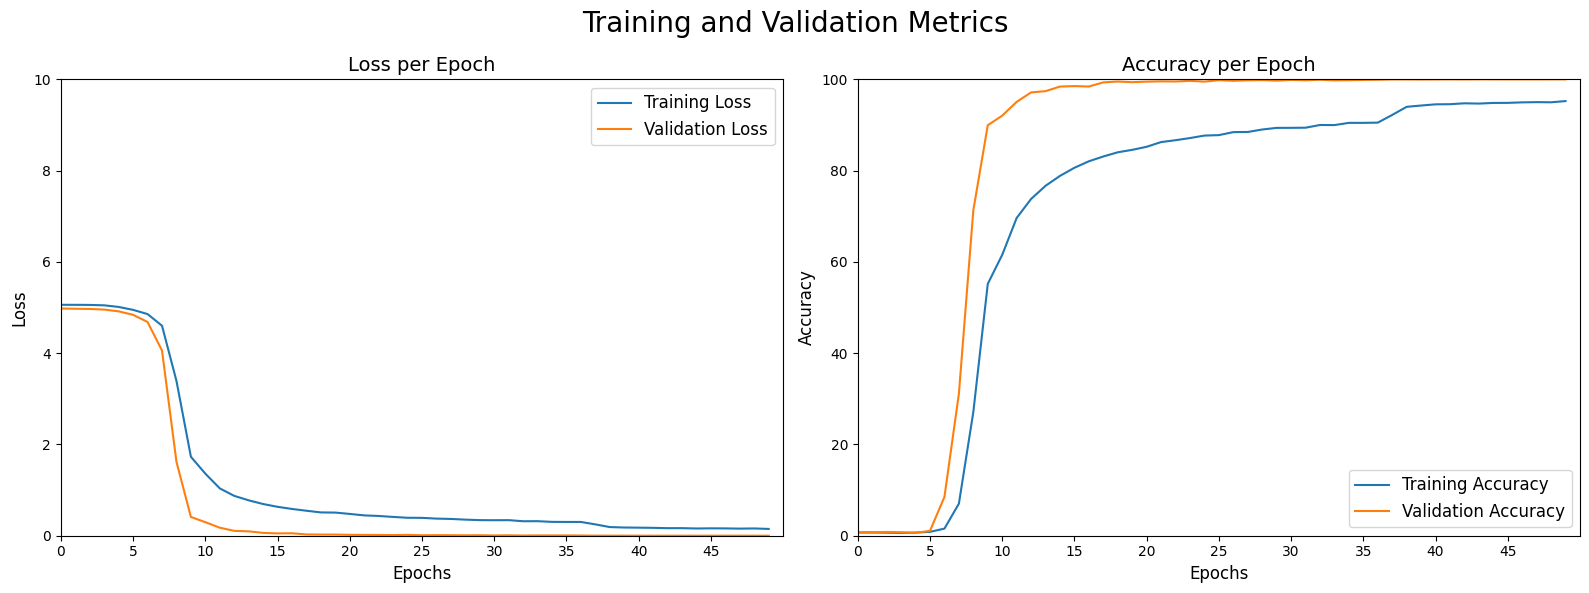

In [14]:
# @title # Training and Validation Graph { vertical-output: true, form-width: "33%", display-mode: "form" }

# Function to concatenate history dictionaries
def concatenate_history(history_list):
    concatenated_history = {}

    for history_dict in history_list:
        for key, value in history_dict.items():
            if key not in concatenated_history:
                concatenated_history[key] = value
            else:
                concatenated_history[key].extend(value)

    return concatenated_history

# Function to plot metrics
def plot_metrics(history, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Loss plot
    axes[0].plot(history["loss"], label="Training Loss")
    axes[0].plot(history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_title("Loss per Epoch", fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].set_xticks(np.arange(0, len(history["loss"]), 5))
    axes[0].set_xticklabels(np.arange(0, len(history["loss"]), 5))
    axes[0].set_xlim(0, len(history["loss"]))
    axes[0].set_ylim(0, 10)

    # Accuracy plot
    axes[1].plot(np.array(history["accuracy"]) * 100, label="Training Accuracy")
    axes[1].plot(np.array(history["val_accuracy"]) * 100, label="Validation Accuracy")
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Accuracy", fontsize=12)
    axes[1].set_title("Accuracy per Epoch", fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].set_xticks(np.arange(0, len(history["accuracy"]), 5))
    axes[1].set_xticklabels(np.arange(0, len(history["accuracy"]), 5))
    axes[1].set_xlim(0, len(history["accuracy"]))
    axes[1].set_ylim(0, 100)

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Concatenate history dictionaries
concatenated_history = concatenate_history(best_history)

# Modify loaded_history to your loaded history data
plot_metrics(concatenated_history, "Training and Validation Metrics")

In [15]:
# @title # Reset Logs { vertical-output: true, form-width: "33%", display-mode: "form" }
RESET = False # @param {type:"boolean"}

if RESET:
    !rm -r {PROJECT_NAME}/logs
    print("Logs resetted.")